In [ ]:
# ruff: noqa: E402, F601, E741

<div style="
    background-color: #f7f7f7;
    background-image: url(''), url('') ;
    background-position: left bottom, right top;
    background-repeat: no-repeat,  no-repeat;
    background-size: auto 60px, auto 160px;
    border-radius: 5px;
    box-shadow: 0px 3px 1px -2px rgba(0, 0, 0, 0.2), 0px 2px 2px 0px rgba(0, 0, 0, 0.14), 0px 1px 5px 0px rgba(0,0,0,.12);">

<h1 style="
    color: #2a4cdf;
    font-style: normal;
    font-size: 2.25rem;
    line-height: 1.4em;
    font-weight: 600;
    padding: 30px 200px 0px 30px;"> 
        Architecture Evolution Analysis of Perovskite Solar Cells</h1>

<p style="
    line-height: 1.4em;
    padding: 30px 200px 0px 30px;">
    This notebook analyzes some aspects of the device stack evolution over time in the field using data from the <a href="https://nomad-lab.eu/prod/v1/staging/gui/search/perovskite-solar-cells-database" target="_blank">Perovskite database in NOMAD</a>.  
</p>

<p style="font-size: 1.25em; font-style: italic; padding: 5px 200px 30px 30px;">
</p>
</div>

In [42]:
from plotly_theme import register_template, set_defaults

register_template()
set_defaults()

In [43]:
# load the data from into a df from the parquet file
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from scipy import stats

# Configure matplotlib to match plotly theme
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 12,
    'axes.linewidth': 1,
    'axes.edgecolor': 'black',
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': 'lightgray',
    'grid.linewidth': 0.5,
    'axes.grid': False,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.facecolor': 'white',
})

df = pd.read_parquet("perovskite_solar_cell_database.parquet")

In [44]:
# set in the df a source_database column. Is data.ref.person_entering_data is LLM Extracted else Manual Entry
df['source_database'] = df['data.ref.name_of_person_entering_the_data'].apply(lambda x: 'LLM Extracted' if x == 'LLM Extraction' else 'Manual Entry')

In [45]:
df['pub_date'] = pd.to_datetime(df['data.ref.publication_date'], errors='coerce')
df['pub_year'] = df['pub_date'].dt.year
df['ETL'] = df['results.properties.optoelectronic.solar_cell.electron_transport_layer']
df['HTL'] = df['results.properties.optoelectronic.solar_cell.hole_transport_layer']
df['absorber'] = df['results.properties.optoelectronic.solar_cell.absorber']
df['PCE'] = df['results.properties.optoelectronic.solar_cell.efficiency']
df['architecture'] = df['data.cell.architecture']

df_early = df[(df['pub_year'] < 2022)]
df_late = df[(df['pub_year'] >= 2022)]

In [46]:
print(f"Early period entries: {len(df_early)}")
print(f"Late period entries: {len(df_late)}")

Early period entries: 43701
Late period entries: 4672


In [47]:
arch_data = df[df['architecture'].isin(['nip', 'pin'])].groupby(['pub_year', 'architecture']).size().unstack(fill_value=0)

In [48]:
arch_data

architecture,nip,pin
pub_year,,
2009.0,2,0
2011.0,6,0
2012.0,18,0
2013.0,215,11
2014.0,1112,431
2015.0,2563,968
2016.0,4312,1899
2017.0,5719,2301
2018.0,7284,3312


In [49]:
arch_pct = arch_data.div(arch_data.sum(axis=1), axis=0) * 100
pin_pct = arch_pct['pin'].to_dict()

In [50]:
def get_three_layer_flows(df_subset):
    abs_htl_flows = {}
    htl_etl_flows = {}

    for _, row in df_subset.iterrows():
        abs_arr = row['absorber']
        htl_arr = row['HTL']
        etl_arr = row['ETL']

        if abs_arr is None or htl_arr is None or etl_arr is None:
            continue
        if not hasattr(abs_arr, '__iter__') or not hasattr(htl_arr, '__iter__') or not hasattr(etl_arr, '__iter__'):
            continue

        # Simplify absorber
        for absorber in abs_arr:
            if not absorber or absorber == 'Unknown':
                continue
            if absorber == 'MAPbI':
                abs_simple = 'MAPbI'
            elif 'CsFA' in absorber or 'FAMA' in absorber:
                abs_simple = 'Mixed'
            elif absorber == 'FAPbI':
                abs_simple = 'FAPbI'
            else:
                abs_simple = 'Other'

            for htl in htl_arr:
                if not htl or htl in {'none', 'Unknown'}:
                    continue
                if 'Spiro' in htl:
                    htl_simple = 'Spiro'
                elif 'PEDOT' in htl:
                    htl_simple = 'PEDOT:PSS'
                elif 'NiO' in htl:
                    htl_simple = 'NiOx'
                elif 'PTAA' in htl:
                    htl_simple = 'PTAA'
                elif 'PACz' in htl or 'SAM' in htl:
                    htl_simple = 'SAMs'
                else:
                    htl_simple = 'Other'

                abs_htl_flows[(abs_simple, htl_simple)] = abs_htl_flows.get((abs_simple, htl_simple), 0) + 1

                for etl in etl_arr:
                    if not etl or etl in {'none', 'Unknown'}:
                        continue
                    if 'TiO2' in etl:
                        etl_simple = 'TiO2'
                    elif 'SnO2' in etl:
                        etl_simple = 'SnO2'
                    elif 'PCBM' in etl or 'PC61BM' in etl:
                        etl_simple = 'PCBM'
                    elif etl == 'C60':
                        etl_simple = 'C60'
                    else:
                        etl_simple = 'Other'

                    htl_etl_flows[(htl_simple, etl_simple)] = htl_etl_flows.get((htl_simple, etl_simple), 0) + 1

    return abs_htl_flows, htl_etl_flows

pre_abs_htl, pre_htl_etl = get_three_layer_flows(df_early)
post_abs_htl, post_htl_etl = get_three_layer_flows(df_late)

In [51]:
def get_global_color_mapping(*flow_pairs):
    """Create consistent color mappings across multiple datasets.

    Args:
        *flow_pairs: Tuples of (abs_htl_flows, htl_etl_flows) for each dataset

    Returns:
        Tuple of (abs_colors, htl_colors, etl_colors) dictionaries
    """
    # Define color palettes matching plotly theme
    COLOR_PALETTES = {
        'absorber': ['#1f77b4', '#ff0e5a', '#e9c821', '#ba78d6', '#4cd8a5', '#ff9408'],
        'htl': ['#ba78d6', '#86d9ea', '#4cd8a5', '#7f7f7f', '#e9c821', '#17becf'],
        'etl': ['#1f77b4', '#4cd8a5', '#ff9408', '#ff0e5a', '#ba78d6', '#86d9ea']
    }

    # Aggregate counts across all datasets
    abs_counts = {}
    htl_counts = {}
    etl_counts = {}

    for abs_htl_flows, htl_etl_flows in flow_pairs:
        for (abs, htl), count in abs_htl_flows.items():
            abs_counts[abs] = abs_counts.get(abs, 0) + count
            htl_counts[htl] = htl_counts.get(htl, 0) + count

        for (htl, etl), count in htl_etl_flows.items():
            htl_counts[htl] = htl_counts.get(htl, 0) + count
            etl_counts[etl] = etl_counts.get(etl, 0) + count

    # Sort by total frequency across all datasets
    abs_labels = sorted(abs_counts.keys(), key=abs_counts.get, reverse=True)
    htl_labels = sorted(htl_counts.keys(), key=htl_counts.get, reverse=True)
    etl_labels = sorted(etl_counts.keys(), key=etl_counts.get, reverse=True)

    # Create consistent color mappings
    abs_colors = {label: COLOR_PALETTES['absorber'][i % len(COLOR_PALETTES['absorber'])]
                  for i, label in enumerate(abs_labels)}
    htl_colors = {label: COLOR_PALETTES['htl'][i % len(COLOR_PALETTES['htl'])]
                  for i, label in enumerate(htl_labels)}
    etl_colors = {label: COLOR_PALETTES['etl'][i % len(COLOR_PALETTES['etl'])]
                  for i, label in enumerate(etl_labels)}

    return abs_colors, htl_colors, etl_colors

In [52]:
def draw_three_layer_alluvial(ax, abs_htl_flows, htl_etl_flows, abs_colors, htl_colors, etl_colors,  # noqa: PLR0913
                               title="", panel_label=""):
    """Draw a 3-layer alluvial diagram: Absorber → HTL → ETL

    Uses provided color mappings for consistency across multiple plots.
    """
    # Extract unique materials from flows and sort by frequency
    abs_counts = {}
    htl_counts = {}
    etl_counts = {}

    for (abs, htl), count in abs_htl_flows.items():
        abs_counts[abs] = abs_counts.get(abs, 0) + count
        htl_counts[htl] = htl_counts.get(htl, 0) + count

    for (htl, etl), count in htl_etl_flows.items():
        htl_counts[htl] = htl_counts.get(htl, 0) + count
        etl_counts[etl] = etl_counts.get(etl, 0) + count

    # Sort materials by count (most common first) within this dataset
    abs_labels = sorted(abs_counts.keys(), key=abs_counts.get, reverse=True)
    htl_labels = sorted(htl_counts.keys(), key=htl_counts.get, reverse=True)
    etl_labels = sorted(etl_counts.keys(), key=etl_counts.get, reverse=True)

    # Calculate totals for normalization
    total_abs_htl = sum(abs_htl_flows.values())
    total_htl_etl = sum(htl_etl_flows.values())

    # Calculate heights for each layer
    abs_heights = {label: abs_counts[label] / total_abs_htl for label in abs_labels}

    htl_heights_left = {}
    htl_heights_right = {}
    for label in htl_labels:
        htl_heights_left[label] = sum(v for (a, h), v in abs_htl_flows.items() if h == label) / total_abs_htl
        htl_heights_right[label] = sum(v for (h, e), v in htl_etl_flows.items() if h == label) / total_htl_etl

    etl_heights = {label: etl_counts[label] / total_htl_etl for label in etl_labels}

    # Positions: x = 0 (Absorber), 0.4 (HTL), 0.8 (ETL)
    x_abs, x_htl, x_etl = 0, 0.4, 0.8
    bar_width = 0.06

    # Draw Absorber nodes
    y_pos = 0
    abs_positions = {}
    for label in abs_labels:
        height = abs_heights[label]
        if height > 0.01:
            rect = plt.Rectangle((x_abs, y_pos), bar_width, height,
                                  facecolor=abs_colors[label],
                                  edgecolor='white', linewidth=1)
            ax.add_patch(rect)
            abs_positions[label] = (y_pos, y_pos + height)
            if height > 0.03:
                ax.text(x_abs - 0.02, y_pos + height/2, label, ha='right', va='center',
                       fontsize=7, fontweight='normal')
            y_pos += height + 0.008

    # Draw HTL nodes (use average of left and right heights)
    y_pos = 0
    htl_positions = {}
    for label in htl_labels:
        height = (htl_heights_left.get(label, 0) + htl_heights_right.get(label, 0)) / 2
        if height > 0.01:
            rect = plt.Rectangle((x_htl, y_pos), bar_width, height,
                                  facecolor=htl_colors[label],
                                  edgecolor='white', linewidth=1)
            ax.add_patch(rect)
            htl_positions[label] = (y_pos, y_pos + height)
            if height > 0.04:
                ax.text(x_htl + bar_width/2, y_pos + height/2, label, ha='center', va='center',
                       fontsize=7, fontweight='normal', rotation=90)
            y_pos += height + 0.008

    # Draw ETL nodes
    y_pos = 0
    etl_positions = {}
    for label in etl_labels:
        height = etl_heights[label]
        if height > 0.01:
            rect = plt.Rectangle((x_etl, y_pos), bar_width, height,
                                  facecolor=etl_colors[label],
                                  edgecolor='white', linewidth=1)
            ax.add_patch(rect)
            etl_positions[label] = (y_pos, y_pos + height)
            if height > 0.03:
                ax.text(x_etl + bar_width + 0.02, y_pos + height/2, label, ha='left', va='center',
                       fontsize=7, fontweight='normal')
            y_pos += height + 0.008

    # Draw flows: Absorber → HTL
    abs_cursors = {l: abs_positions[l][0] for l in abs_positions}
    htl_cursors_left = {l: htl_positions[l][0] for l in htl_positions}

    for (abs_label, htl_label), value in sorted(abs_htl_flows.items(), key=lambda x: -x[1]):
        if abs_label not in abs_positions or htl_label not in htl_positions:
            continue

        height = value / total_abs_htl
        if height < 0.005:
            continue

        y_abs = abs_cursors[abs_label]
        y_htl = htl_cursors_left[htl_label]

        verts = [
            (x_abs + bar_width, y_abs),
            (x_abs + bar_width + 0.1, y_abs),
            (x_htl - 0.1, y_htl),
            (x_htl, y_htl),
            (x_htl, y_htl + height),
            (x_htl - 0.1, y_htl + height),
            (x_abs + bar_width + 0.1, y_abs + height),
            (x_abs + bar_width, y_abs + height),
            (x_abs + bar_width, y_abs),
        ]

        codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4,
                 Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, Path.CLOSEPOLY]

        path = Path(verts, codes)
        patch = PathPatch(path, facecolor=abs_colors[abs_label], alpha=0.4, edgecolor='none')
        ax.add_patch(patch)

        abs_cursors[abs_label] += height
        htl_cursors_left[htl_label] += height

    # Draw flows: HTL → ETL
    htl_cursors_right = {l: htl_positions[l][0] for l in htl_positions}
    etl_cursors = {l: etl_positions[l][0] for l in etl_positions}

    for (htl_label, etl_label), value in sorted(htl_etl_flows.items(), key=lambda x: -x[1]):
        if htl_label not in htl_positions or etl_label not in etl_positions:
            continue

        height = value / total_htl_etl
        if height < 0.005:
            continue

        y_htl = htl_cursors_right[htl_label]
        y_etl = etl_cursors[etl_label]

        verts = [
            (x_htl + bar_width, y_htl),
            (x_htl + bar_width + 0.1, y_htl),
            (x_etl - 0.1, y_etl),
            (x_etl, y_etl),
            (x_etl, y_etl + height),
            (x_etl - 0.1, y_etl + height),
            (x_htl + bar_width + 0.1, y_htl + height),
            (x_htl + bar_width, y_htl + height),
            (x_htl + bar_width, y_htl),
        ]

        codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4,
                 Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, Path.CLOSEPOLY]

        path = Path(verts, codes)
        patch = PathPatch(path, facecolor=htl_colors[htl_label], alpha=0.4, edgecolor='none')
        ax.add_patch(patch)

        htl_cursors_right[htl_label] += height
        etl_cursors[etl_label] += height

    # Add layer labels
    ax.text(x_abs + bar_width/2, -0.02, 'Absorber', ha='center', va='top',
           fontsize=8)
    ax.text(x_htl + bar_width/2, -0.02, 'HTL', ha='center', va='top',
           fontsize=8)
    ax.text(x_etl + bar_width/2, -0.02, 'ETL', ha='center', va='top',
           fontsize=8)

    # Add panel label (a, b, etc.)
    if panel_label:
        ax.text(-0.15, 1.02, panel_label, fontsize=14, fontweight='bold',
               ha='left', va='bottom', transform=ax.transAxes)

    # Add title
    if title:
        ax.text(0.5, 1.02, title, fontsize=10, fontweight='bold',
               ha='center', va='bottom', transform=ax.transAxes)

    ax.set_xlim(-0.15, 1.0)
    ax.set_ylim(-0.12, 1.05)
    ax.axis('off')

In [53]:
def get_architecture_evolution(df):
    """Get PIN vs NIP percentages by year."""
    arch_by_year = df[df['architecture'].isin(['nip', 'pin'])].groupby(['pub_year', 'architecture']).size().unstack(fill_value=0)
    arch_pct = arch_by_year.div(arch_by_year.sum(axis=1), axis=0) * 100
    return arch_pct

def get_etl_evolution(df):
    """Get TiO2 and SnO2 percentages by year."""
    etl_by_year = {}

    for year in sorted(df['pub_year'].dropna().unique()):
        df_year = df[df['pub_year'] == year]
        all_etls = []

        for _, row in df_year.iterrows():
            etl_arr = row['ETL']
            if etl_arr is None or not hasattr(etl_arr, '__iter__'):
                continue
            for etl in etl_arr:
                if etl and etl not in {'none', 'Unknown'}:
                    all_etls.append(etl)

        if len(all_etls) == 0:
            continue

        # Count TiO2 and SnO2
        tio2_count = sum(1 for e in all_etls if 'TiO2' in e)
        sno2_count = sum(1 for e in all_etls if 'SnO2' in e)
        total = len(all_etls)

        etl_by_year[year] = {
            'TiO2': tio2_count / total * 100,
            'SnO2': sno2_count / total * 100
        }

    return pd.DataFrame(etl_by_year).T

# Get evolution data
arch_evolution = get_architecture_evolution(df)
etl_evolution = get_etl_evolution(df)

print("Architecture evolution:")
print(arch_evolution)
print("\nETL evolution:")
print(etl_evolution)

Architecture evolution:
architecture         nip        pin
pub_year                           
2009.0        100.000000   0.000000
2011.0        100.000000   0.000000
2012.0        100.000000   0.000000
2013.0         95.132743   4.867257
2014.0         72.067401  27.932599
2015.0         72.585670  27.414330
2016.0         69.425213  30.574787
2017.0         71.309227  28.690773
2018.0         68.742922  31.257078
2019.0         69.715791  30.284209
2020.0         66.541756  33.458244
2021.0         71.464646  28.535354
2022.0         57.087753  42.912247
2023.0         68.902920  31.097080
2024.0         65.878594  34.121406
2025.0         56.202144  43.797856

ETL evolution:
              TiO2       SnO2
2009.0  100.000000   0.000000
2011.0  100.000000   0.000000
2012.0   94.285714   0.000000
2013.0   77.294686   0.000000
2014.0   65.475743   0.000000
2015.0   62.765407   1.018471
2016.0   57.076476   2.333011
2017.0   55.780584   3.871161
2018.0   48.009616   7.212345
2019.0   44.

/var/folders/mj/9kp8r_ms2sg02prl56qtbnmc0000gn/T/ipykernel_41747/2845536860.py:60: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



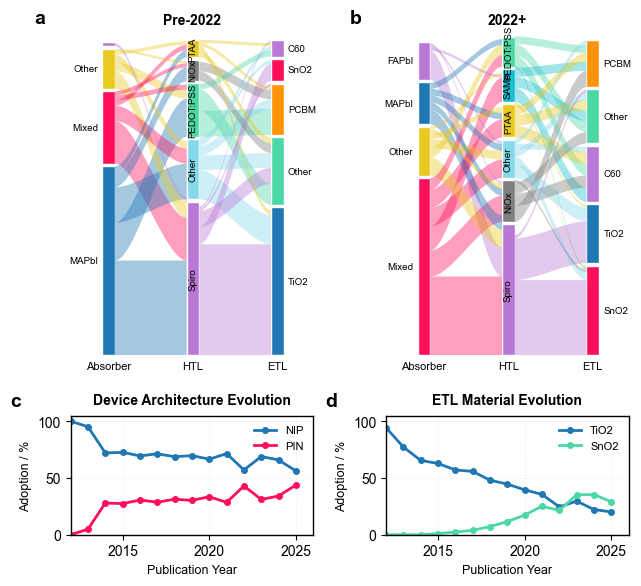

In [54]:
# Create consistent color mapping across both periods
abs_colors, htl_colors, etl_colors = get_global_color_mapping(
    (pre_abs_htl, pre_htl_etl),
    (post_abs_htl, post_htl_etl)
)

# Define colors for line plots (from plotly theme)
arch_colors = {'pin': '#ff0e5a', 'nip': '#1f77b4'}
etl_line_colors = {'TiO2': '#1f77b4', 'SnO2': '#4cd8a5'}

# Create 2x2 Nature figure with taller alluvial plots (panels a, b)
# height_ratios makes top row 1.5x taller than bottom row
fig = plt.figure(figsize=(7.2, 6.5))
gs = fig.add_gridspec(2, 2, hspace=0.1, wspace=0.3, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Draw alluvial diagrams (panels a, b)
draw_three_layer_alluvial(ax1, pre_abs_htl, pre_htl_etl, abs_colors, htl_colors, etl_colors,
                          title="Pre-2022", panel_label="a")
draw_three_layer_alluvial(ax2, post_abs_htl, post_htl_etl, abs_colors, htl_colors, etl_colors,
                          title="2022+", panel_label="b")

# Draw architecture evolution (panel c)
ax3.text(-0.25, 1.05, 'c', fontsize=14, fontweight='bold',
        ha='left', va='bottom', transform=ax3.transAxes)

for arch in arch_evolution.columns:
    ax3.plot(arch_evolution.index, arch_evolution[arch], 'o-',
            label=arch.upper(), color=arch_colors[arch], linewidth=2, markersize=4)

ax3.set_xlabel('Publication Year', fontsize=9)
ax3.set_ylabel('Adoption / %', fontsize=9)
ax3.set_title('Device Architecture Evolution', fontsize=10, fontweight='bold', pad=8)
ax3.legend(frameon=False, fontsize=8, loc='best')
ax3.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax3.set_xlim(2012, 2026)
ax3.set_ylim(0, 105)

# Draw ETL material evolution (panel d)
ax4.text(-0.25, 1.05, 'd', fontsize=14, fontweight='bold',
        ha='left', va='bottom', transform=ax4.transAxes)

for etl in ['TiO2', 'SnO2']:
    if etl in etl_evolution.columns:
        ax4.plot(etl_evolution.index, etl_evolution[etl], 'o-',
                label=etl, color=etl_line_colors[etl], linewidth=2, markersize=4)

ax4.set_xlabel('Publication Year', fontsize=9)
ax4.set_ylabel('Adoption / %', fontsize=9)
ax4.set_title('ETL Material Evolution', fontsize=10, fontweight='bold', pad=8)
ax4.legend(frameon=False, fontsize=8, loc='best')
ax4.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax4.set_xlim(2012, 2026)
ax4.set_ylim(0, 105)

fig.tight_layout()
fig.savefig("perovskite_solar_cell_evolution_figure.pdf",)